# Gaussian Process Regression (for large data)

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using Plots

We create a toy dataset with `x ∈ [-10, 10]` and `y = 5 * sinc(X)``

In [2]:
N = 1000
x = (sort(rand(N)) .- 0.5) * 20.0
σ = 0.01 # Standard gaussian noise

function latent(x)
    return 5.0 * sinc.(x)
end
y = latent(x) + σ * randn(N);

Visualization of the data :

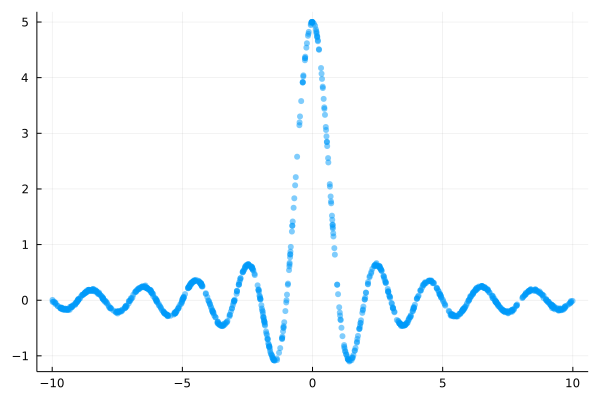

In [3]:
scatter(x, y; lab="")

## Gaussian noise

In this first example we are going to look at the effect of using
inducing points compared to the true Gaussian Process
For simplicity we will keep all inducing points and kernel parameters fixed

In [4]:
Ms = [4, 8, 16, 32, 64];

Create an empty array of GPs

In [5]:
models = Vector{AbstractGPModel}(undef, length(Ms) + 1);

Chose a kernel

In [6]:
kernel = with_lengthscale(SqExponentialKernel(), 1.0);

And Run sparse classification with an increasing number of inducing points

In [7]:
for (index, num_inducing) in enumerate(Ms)
    @info "Training with $(num_inducing) points"
    m = SVGP(
        kernel, # Kernel
        GaussianLikelihood(σ), # Likelihood used
        AnalyticVI(), # Inference usede to solve the problem
        range(-10, 10; length=num_inducing); # Simple range
        optimiser=false, # Keep kernel parameters fixed
        Zoptimiser=false, # Keep inducing points locations fixed
    )
    @time train!(m, x, y, 100) # Train the model for 100 iterations
    models[index] = m # Save the model in the array
end

[ Info: Training with 4 points
  4.444886 seconds (10.70 M allocations: 537.099 MiB, 9.92% gc time, 99.60% compilation time)
[ Info: Training with 8 points
  0.011173 seconds (13.70 k allocations: 25.667 MiB)
[ Info: Training with 16 points
  0.026761 seconds (13.70 k allocations: 46.256 MiB)
[ Info: Training with 32 points
  0.115569 seconds (13.70 k allocations: 90.278 MiB, 40.05% gc time)
[ Info: Training with 64 points
  0.126962 seconds (14.71 k allocations: 190.037 MiB, 16.22% gc time)


Train the model without any inducing points (no approximation)

In [8]:
@info "Training with full model"
mfull = GP(
    x,
    y,
    kernel;
    noise=σ,
    opt_noise=false, # Keep the noise value fixed
    optimiser=false, # Keep kernel parameters fixed
)
@time train!(mfull, 5);
models[end] = mfull;

[ Info: Training with full model
  0.532043 seconds (249.41 k allocations: 380.372 MiB, 9.67% gc time, 20.45% compilation time)


Create a grid and compute prediction on it

In [9]:
function compute_grid(model, n_grid=50)
    mins = -10
    maxs = 10
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end;

Plot the data as a scatter plot

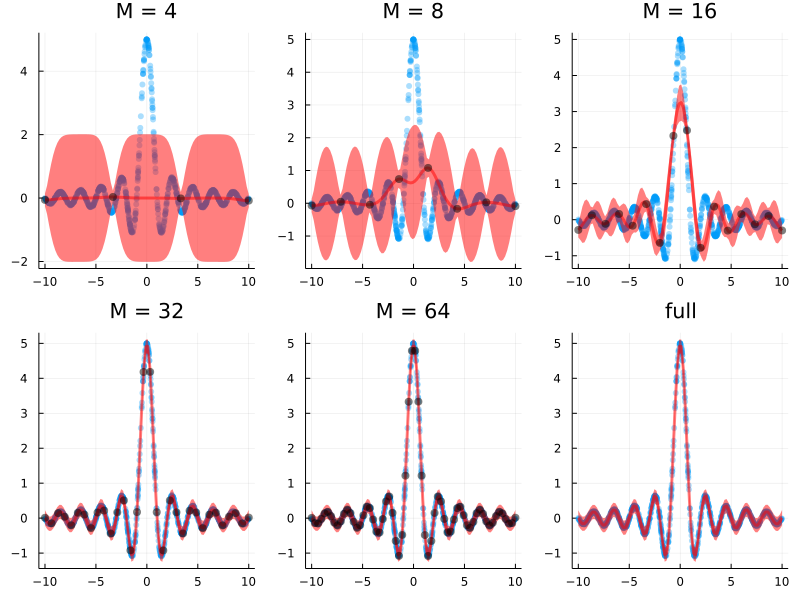

In [10]:
function plotdata(x, y)
    return Plots.scatter(x, y; alpha=0.33, msw=0.0, lab="", size=(300, 500))
end

function plot_model(model, x, y, title=nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model, n_grid)
    title = if isnothing(title)
        (model isa SVGP ? "M = $(dim(model[1]))" : "full")
    else
        title
    end

    p = plotdata(x, y)
    Plots.plot!(
        p,
        x_grid,
        y_grid;
        ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
        title=title,
        color="red",
        lab="",
        linewidth=3.0,
    )
    if model isa SVGP # Plot the inducing points as well
        Plots.plot!(
            p,
            model.f[1].Z,
            mean(model.f[1]);
            msize=5.0,
            color="black",
            t=:scatter,
            lab="",
        )
    end
    return p
end;

Plots.plot(
    plot_model.(models, Ref(x), Ref(y))...; layout=(2, 3), size=(800, 600)
) # Plot all models and combine the plots

## Non-Gaussian Likelihoods
We now look at using another noise than Gaussian noise.
In AGP.jl you can use the Student-T likelihood,
the Laplace likelihood and the Heteroscedastic likelihood

We will use the same toy dataset for our experiment

Create an array of model with different likelihoods:

In [11]:
likelihoods = [
    StudentTLikelihood(3.0), LaplaceLikelihood(3.0), HeteroscedasticLikelihood(1.0)
]
ngmodels = Vector{AbstractGPModel}(undef, length(likelihoods) + 1)
for (i, l) in enumerate(likelihoods)
    @info "Training with the $(l)" # We need to use VGP
    m = VGP(
        x,
        y, # First arguments are the input and output
        kernel, # Kernel
        l, # Likelihood used
        AnalyticVI(); # Inference usede to solve the problem
        optimiser=false, # Keep kernel parameters fixed
    )
    @time train!(m, 10) # Train the model for 100 iterations
    ngmodels[i] = m # Save the model in the array
end

ngmodels[end] = models[end] # Add the Gaussian model

[ Info: Training with the Student-t likelihood (ν=3.0, σ=1.0)
  1.765775 seconds (1.84 M allocations: 702.602 MiB, 6.93% gc time, 53.61% compilation time)
[ Info: Training with the Laplace likelihood (β=3.0)
  1.524517 seconds (1.27 M allocations: 672.825 MiB, 4.08% gc time, 48.44% compilation time)
[ Info: Training with the Gaussian likelihood with heteroscedastic noise
  3.374120 seconds (3.94 M allocations: 1.389 GiB, 3.83% gc time, 52.40% compilation time)


Gaussian Process with a Gaussian likelihood (σ² = 0.01) infered by Analytic Inference 

We can now repeat the prediction from before :

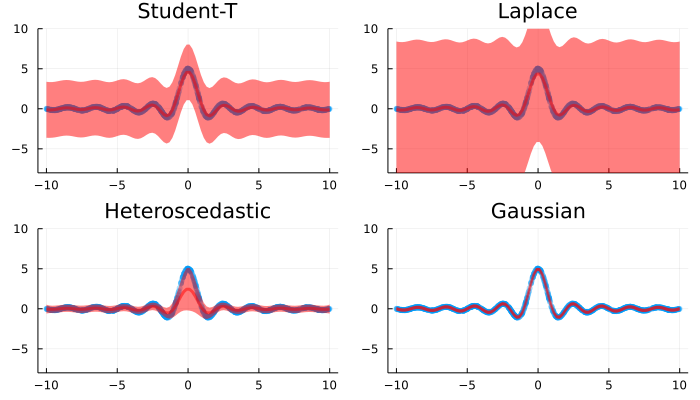

In [12]:
Plots.plot(
    plot_model.(
        ngmodels, Ref(x), Ref(y), ["Student-T", "Laplace", "Heteroscedastic", "Gaussian"]
    )...;
    layout=(2, 2),
    ylims=(-8, 10),
    size=(700, 400),
)# Plot all models and combine the plots

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*